In [1]:
%%html

<style>    
    @import url("css/custom_styles.css")
</style>

In [2]:
%matplotlib inline

#
# import utilitaires
#
import matplotlib.pyplot as plt
import os
import pandas as pd
import random

import helpers as hlp
import helpers.dataset.PlantVillage as pv
import helpers.features as feat

In [3]:
#
# parametres dataset PlantVillage
#
config_overrides = hlp.MetaObject.from_json("config_overrides.json")
executor = hlp.create_thread_pool_executor(max_workers=None)

pv_config = pv.Config(executor)
if not config_overrides is None:
    hlp.MetaObject.override_from_object(pv_config, 
                                        config_overrides.dataset)

print("pv_config")
display(vars(pv_config))

#
# obtenir le dataset PlantVillage
#
with hlp.Profile() as pv_loading:
    pv_dataset = pv.load(pv_config)

    if pv_dataset is None:
        print("Invalid dataset")
    else:
        pv_dataframe = pv_dataset.dataframe

print(f"Loading dataset: {round(pv_loading.duration, 2)}s")
print("PlantVillage", pv_dataframe.shape)
display( pv_dataframe.head() )

pv_config


{'url': 'https://tinyurl.com/22tas3na',
 'install_path': 'dataset/PlantVillage.hd5',
 'species_disease_re': '(.*)(?:___)(.*)',
 'species_re': '(.*)(?:,_|_)(.*)',
 'label_separator': '_',
 'thumbnail_scale': 0.25,
 'force_download': False,
 'read_only': True,
 'executor': <concurrent.futures.thread.ThreadPoolExecutor at 0x1fadaede070>,
 'force_install': False}

Loading dataset: 0.76s
PlantVillage (60343, 5)


,species,disease,label,image_path,thumbnail_path
0,Apple,Apple_scab,Apple_scab,Plant_leave_diseases_dataset_with_augmentation...,thumbnails/Plant_leave_diseases_dataset_with_a...
1,Apple,Apple_scab,Apple_scab,Plant_leave_diseases_dataset_with_augmentation...,thumbnails/Plant_leave_diseases_dataset_with_a...
2,Apple,Apple_scab,Apple_scab,Plant_leave_diseases_dataset_with_augmentation...,thumbnails/Plant_leave_diseases_dataset_with_a...
3,Apple,Apple_scab,Apple_scab,Plant_leave_diseases_dataset_with_augmentation...,thumbnails/Plant_leave_diseases_dataset_with_a...
4,Apple,Apple_scab,Apple_scab,Plant_leave_diseases_dataset_with_augmentation...,thumbnails/Plant_leave_diseases_dataset_with_a...


In [4]:
#
# parametres pour features orb
#
orb_features_config = feat.OrbFeaturesConfig(executor)
if not orb_features_config is None:
    hlp.MetaObject.override_from_object(orb_features_config, 
                                        config_overrides.orb.features)

print("orb_features_config")
display(vars(orb_features_config))

# pour debugger, s'assurer que le fichier de features 
# est detruit a chaque execution de la cellule
if "features_orb" in locals():
    del features_orb

with hlp.Profile() as orb_loading:
    #
    # obtenir les orb features pour chaque image du dataset
    #
    orb_iter = feat.DatasetIter(pv_dataset, 
                                pv_dataframe["image_path"].iteritems(),
                                pv_dataframe.shape[0])

    features_orb = feat.load(orb_features_config, orb_iter)

print(f"ORB loading: {round(orb_loading.duration, 2)}s")
print("ORB features", features_orb.features.shape)
print("ORB keypoints", features_orb.key_points.shape)

orb_features_config


{'install_path': 'dataset/OrbFeatures.hd5',
 'force_generate': False,
 'read_only': True,
 'executor': <concurrent.futures.thread.ThreadPoolExecutor at 0x1fadaede070>,
 'chunk_size': 150,
 'nfeatures': 500}

ORB loading: 0.02s
ORB features (20908751, 32)
ORB keypoints (20908751, 7)


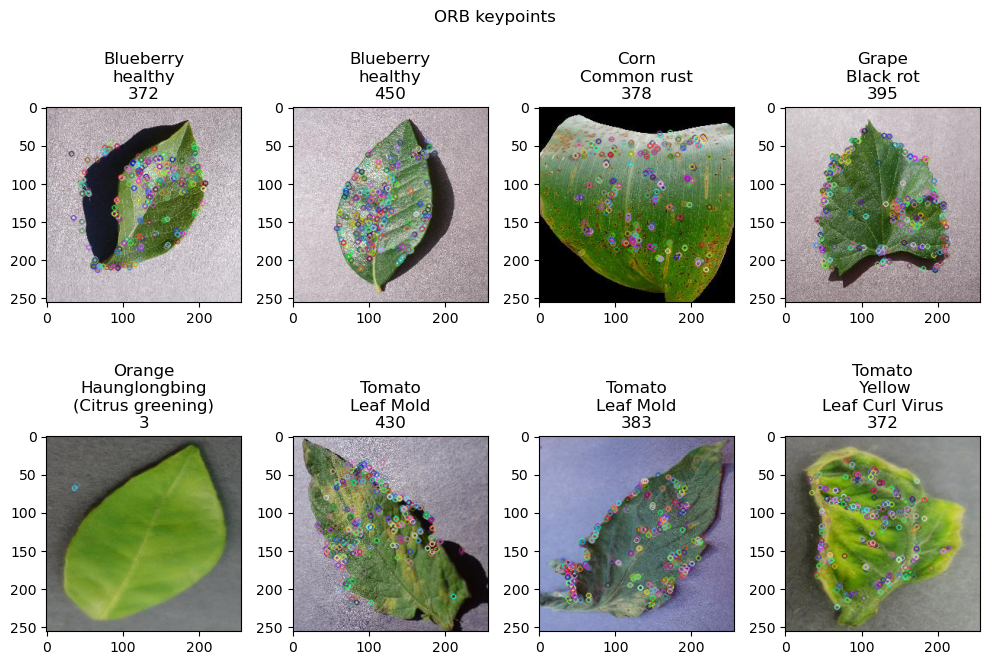

In [5]:
#
# visualiser quelques orb keypoints
#
SAMPLES_GRID = (2, 4)
FIGSIZE = (10, SAMPLES_GRID[0] * 3.5)

# selectionner quelques images aleatoirement
random.seed(55)
indices = random.sample(range(pv_dataframe.shape[0]), SAMPLES_GRID[0] * SAMPLES_GRID[1])
indices.sort()

orb_iter = feat.DatasetIter(pv_dataset, 
                            pv_dataframe.loc[indices, "image_path"].iteritems())

_, axes = plt.subplots(SAMPLES_GRID[0], SAMPLES_GRID[1], figsize=FIGSIZE)
for ax, \
   (image_index, \
    _, \
    key_points_count, \
    key_points_image) in zip(axes.flatten(), feat.key_points_iter(features_orb, orb_iter)):    
    plt.sca(ax)
    
    species, disease = pv_dataframe.loc[image_index, ["species", "disease"]]
    disease = pv.attribute_prettify(species, disease)
    title = "\n".join([species, disease, str(key_points_count)])
    
    plt.title(title)
    plt.imshow(key_points_image)

plt.suptitle("ORB keypoints")
plt.tight_layout()
plt.show()

In [6]:
#
# parametres pour features sift
#
sift_features_config = feat.SiftFeaturesConfig(executor)
if not sift_features_config is None:
    hlp.MetaObject.override_from_object(sift_features_config, 
                                        config_overrides.sift.features)

print("sift_features_config")
display(vars(sift_features_config))

# pour debugger, s'assurer que le fichier de features 
# est detruit a chaque execution de la cellule
if "features_sift" in locals():
    del features_sift

with hlp.Profile() as sift_loading:
    #
    # obtenir les sift features pour chaque image du dataset
    #
    sift_iter = feat.DatasetIter(pv_dataset, 
                                 pv_dataframe["image_path"].iteritems(),
                                 pv_dataframe.shape[0])

    features_sift = feat.load(sift_features_config, sift_iter)

print(f"SIFT loading: {round(sift_loading.duration, 2)}s")
print("SIFT features", features_sift.features.shape)
print("SIFT keypoints", features_sift.key_points.shape)

sift_features_config


{'install_path': 'dataset/SiftFeatures.hd5',
 'force_generate': False,
 'read_only': True,
 'executor': <concurrent.futures.thread.ThreadPoolExecutor at 0x1fadaede070>,
 'chunk_size': 150,
 'nfeatures': 500}

SIFT loading: 0.01s
SIFT features (14386568, 128)
SIFT keypoints (14386568, 7)


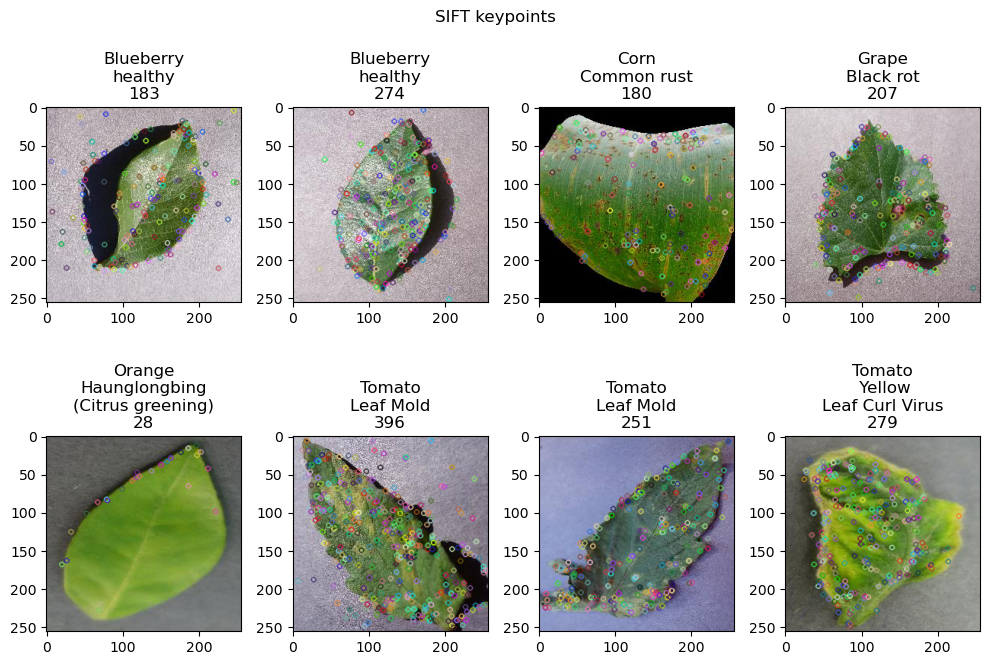

In [7]:
#
# visualiser quelques sift keypoints (les memes que orb)
#

sift_iter = feat.DatasetIter(pv_dataset, 
                             pv_dataframe.loc[indices, "image_path"].iteritems())

_, axes = plt.subplots(SAMPLES_GRID[0], SAMPLES_GRID[1], figsize=FIGSIZE)
for ax, \
   (image_index, \
    _, \
    key_points_count, \
    key_points_image) in zip(axes.flatten(), feat.key_points_iter(features_sift, sift_iter)):    
    plt.sca(ax)
    
    species, disease = pv_dataframe.loc[image_index, ["species", "disease"]]
    disease = pv.attribute_prettify(species, disease)
    title = "\n".join([species, disease, str(key_points_count)])
    
    plt.title(title)
    plt.imshow(key_points_image)

plt.suptitle("SIFT keypoints")
plt.tight_layout()
plt.show()